# Explore Multivariate Regression kNN, polynomials, and decision trees are used to optimize a model that predicts the course of diabetes

The toy dataset for diabetes progression from Scikit-Learn is used to train the model. The model can be used to forecast and validate the model accuracy based on the data obtained from each patient and the actual diabetes level reported for the same patients one year after the baseline. For this reason, the data will be divided into three categories: training, validation, and test.

In [1]:
# Import libraries if required

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

##  LOAD DATASET

The dataset's values were adjusted by multiplying the standard deviation by the square root of the number of samples, then centered around the mean. Before diving deeper into the data, we will first analyze the non-scaled data by setting scaled=False, followed by the training procedure on the scaled data.

In [33]:
dia_ds = datasets.load_diabetes(return_X_y=False, as_frame=False, scaled=False)
X = dia_ds.data[:,[2,9]] # using all features
y = dia_ds.target

The diabetes dataset comprises data from 442 patients and includes the following features:

- age (age in years)
- sex
- bmi (body mass index)
- bp (average blood pressure)
- s1 tc (total serum cholesterol)
- s2 ldl (low-density lipoproteins)
- s3 hdl (high-density lipoproteins)
- s4 tch (total cholesterol / HDL)
- s5 ltg (possibly log of serum triglycerides level)
- s6 glu (blood sugar level)
The 'target' data contains a record of how diabetes progressed in the patients after a year.

### Sample rows from both the dataset and the intended diabetes progression outcome

In [5]:
pa_ds = pd.DataFrame(dia_ds.data, columns=dia_ds.feature_names)
pa_ds.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


In [6]:
T_df = pd.DataFrame(dia_ds.target)
T_df.head(5)

,0
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


The model's X-axis depicts the patient's BMI, while the Y-axis depicts the expected diabetes results. We will run polynomial regressions using all relevant features and use cross-validation to determine the best degree of polynomial for the regression, avoiding overfitting.



To do this, we will first analyze the data by investigating statistics using histograms and correlation matrices.

## EXPLORATORY DATA ANALYSIS

In [7]:
pa_ds.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


According to the dataset's description, the patients ranged in age from 19 to 79 years old, with a BMI of 18 to 42. So the data does not focus on a certain age group, gender, or BMI. We can train a good prediction model using the many data sources available. The data already indicates *s6* glucose levels of patients, with the maximum being merely 124. So the data source is a sample of patients with normal glucose levels at the start, making it suitable for predicting the progression.

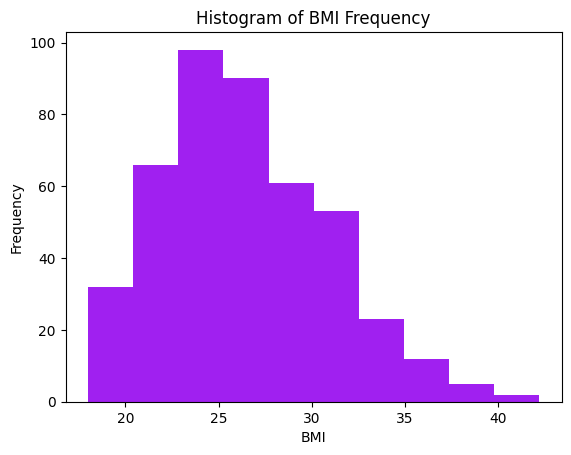

In [21]:
plt.hist(X[:,0], color="#A020F0")
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI Frequency')
plt.show()

Based on the histogram depicting the frequency of BMI in the dataset, most patients fell within the BMI range of 21 to 32. Approximately 50 individuals had a BMI around 20, while the collective count of individuals with a BMI greater than 32 was approximately 35.

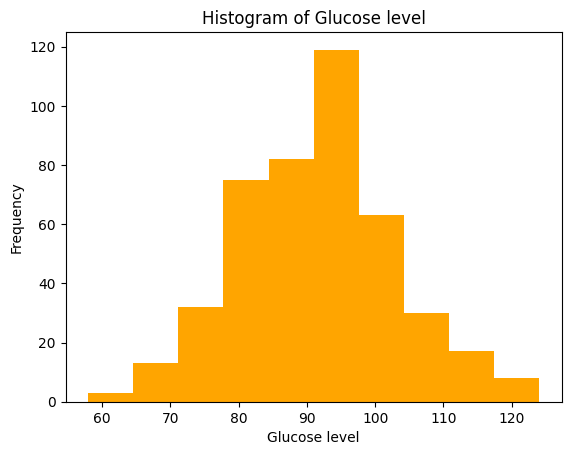

In [16]:
plt.hist(X[:,1], color="orange")
plt.xlabel('Glucose level')
plt.ylabel('Frequency')
plt.title('Histogram of Glucose level')
plt.show()

Based on the histogram, it is evident that the majority of individuals in the dataset have a BMI within the 21 to 32 range. This range is where the frequency of BMI is highest. Additionally, there is a spike at around 20 BMI, with approximately 50 individuals falling into this category. Moreover, the number of individuals with a BMI greater than 32 collectively amounts to around 35.

In [13]:
cor_matrix = pa_ds.corr()
cor_matrix.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000


The correlation matrix illustrates the relationship between each column in the dataset. In this prediction model, the relevant columns are BMI and glucose level. Despite the modest value, there is a positive correlation of 0.388680, indicating that as BMI increases, an elevated glucose level is observed.

## SPLIT the TEST DATA

In [14]:
# Check if the data needs cleaning
missing_val = pa_ds.isnull().sum()
print("Missing Values:")
print(missing_val)

Missing Values:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


The dataset contains no missing values and thus requires no cleaning. We can proceed to split the training data and test the model.

In [22]:
# Split the dataset into 80% train and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Result array
results = []

## Create the specified models and conduct cross-validation as follows:

Develop 2 polynomial regression models with degrees 5 and 7.

Build 2 decision tree models with maximum depths of 3 and 5.

Create 2 KNN models with 2 and 7 neighbors.

To ensure clarity and structure, organize the model fitting process into separate loops for each model type.

In [23]:
# Initialize polynomial models
poly_mod = [
    ('Polynomial Regression (degree=5)', PolynomialFeatures(degree=5), LinearRegression()),
    ('Polynomial Regression (degree=7)', PolynomialFeatures(degree=7), LinearRegression())
]

# Fit polynomial models
for name, features, model in poly_mod:
    train_poly = features.fit_transform(X_train_scaled)
    model.fit(train_poly, y_train)
    cross_sc = cross_validate(model, train_poly, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cross_sc['test_r2']),
        'R-Squared Std': np.std(cross_sc['test_r2']),
        'MAE-Mean': -np.mean(cross_sc['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cross_sc['test_neg_mean_absolute_error'])
    })

In [24]:
tree_models = [
    ('Decision Tree (max_depth=3)', DecisionTreeRegressor(max_depth=3)),
    ('Decision Tree (max_depth=5)', DecisionTreeRegressor(max_depth=5)),
]

for name, model in tree_models:
    model.fit(X_train_scaled, y_train)
    cross_sc = cross_validate(model, X_train_scaled, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cross_sc['test_r2']),
        'R-Squared Std': np.std(cross_sc['test_r2']),
        'MAE-Mean': -np.mean(cross_sc['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cross_sc['test_neg_mean_absolute_error'])
    })

In [25]:
knn_models = [
    ('kNN (n_neighbors=2)', KNeighborsRegressor(n_neighbors=2)),
    ('kNN (n_neighbors=7)', KNeighborsRegressor(n_neighbors=7))
]

for name, model in knn_models:
    model.fit(X_train_scaled, y_train)
    cross_sc = cross_validate(model, X_train_scaled, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    results.append({
        'Model': name,
        'Model Instance': model,
        'R-Squared Mean': np.mean(cross_sc['test_r2']),
        'R-Squared Std': np.std(cross_sc['test_r2']),
        'MAE-Mean': -np.mean(cross_sc['test_neg_mean_absolute_error']),
        'MAE-Std': np.std(cross_sc['test_neg_mean_absolute_error'])
    })

In [26]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Model Instance,R-Squared Mean,R-Squared Std,MAE-Mean,MAE-Std
0,Polynomial Regression (degree=5),LinearRegression(),0.305176,0.130262,52.557615,3.922580
1,Polynomial Regression (degree=7),LinearRegression(),-4.183237,6.283975,82.395747,36.919165
2,Decision Tree (max_depth=3),DecisionTreeRegressor(max_depth=3),0.297212,0.176811,52.577075,4.490611
3,Decision Tree (max_depth=5),DecisionTreeRegressor(max_depth=5),0.205928,0.216172,54.788568,6.132630
4,kNN (n_neighbors=2),KNeighborsRegressor(n_neighbors=2),0.054517,0.261067,59.081147,8.142837
5,kNN (n_neighbors=7),KNeighborsRegressor(n_neighbors=7),0.249947,0.155471,53.717045,4.213777


In [27]:
best_model = results_df.loc[results_df['R-Squared Mean'].idxmax()]
print("Best Model:")
best_model

Best Model:


Model             Polynomial Regression (degree=5)
Model Instance                  LinearRegression()
R-Squared Mean                            0.305176
R-Squared Std                             0.130262
MAE-Mean                                 52.557615
MAE-Std                                    3.92258
Name: 0, dtype: object

In [29]:
# Predict on the test set
pred_test = []
best_model_train = []
if 'Polynomial' in best_model['Model']:
    X_train_transformed = PolynomialFeatures(degree=int(best_model['Model'][-2])).fit_transform(X_train_scaled)
    X_test_transformed = PolynomialFeatures(degree=int(best_model['Model'][-2])).fit_transform(X_test_scaled)
    pred_test = X_test_transformed
    best_model_train = X_train_transformed
else:
    pred_test = X_test_scaled
    best_model_train = X_train_scaled

y_pred = best_model['Model Instance'].predict(pred_test)

## Prediction using the best model on the test dataset

In [30]:
# Calculate R-Squared, MAE, and MAPE
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [31]:
# Display results
print("\nTest Set Results:")
print(f"R-Squared: {r_squared:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")


Test Set Results:
R-Squared: 0.3271
MAE: 48.7091
MAPE: 42.6173%


## Graph plot for fitted model

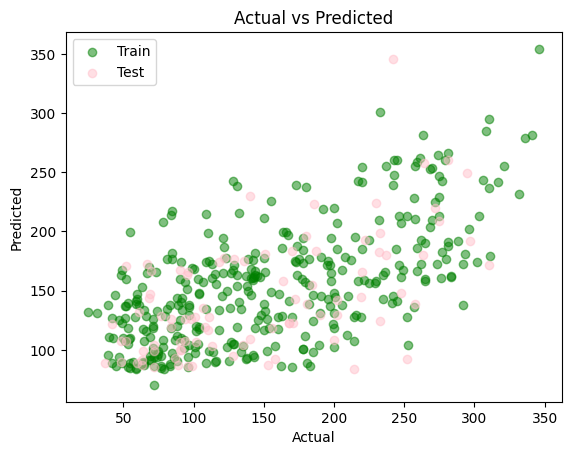

In [32]:
# Plot the data points and the fitted model
plt.scatter(y_train, best_model['Model Instance'].predict(best_model_train), label='Train', color='green', alpha=0.5)
plt.scatter(y_test, y_pred, label='Test', color='pink', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

## Conclusion

The best model derived from Polynomial regression degree 5 exhibits certain limitations. Specifically, there are concerns about high residuals for some data points. Despite this, there is a notable similarity between the actual data points and the predicted ones, suggesting a relatively close fit.

It is important to recognize that while the models perform well on test data, their real-world applicability remains uncertain without regular testing. As a result, it is crucial to remain aware of these limitations and to continuously refine the models for reliable predictions.

Furthermore, the quest for the best diabetes progression prediction model relies on cross-validation performance. It is notable that decision trees excel at highlighting significant features, while polynomial regression has shown promising performance.